c:\Python311\Lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8608\2665025314.py:52: FutureWarning: Pass y=[0.         0.         0.         ... 0.002148   0.00248539 0.00452035] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8608\2665025314.py:52: FutureWarning: Pass y=[0.06011968 0.08860151 0.06173805 ... 0.06427395 0.05268883 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8608\2665025314.py:52: FutureWarning: Pass y=[ 1.9149822e-03  2.0409347e-03  1.4658804e-03 ... -4.3577853e-05
  7.7795685e-06  0.0000000e+00

1/1 [==============================] - 1s 922ms/step
Round No 5 -
Individual Prediction : [0.0, 0.0, 1.0, 0.0] -> 2   |  [0.0062, 1e-04, 0.001, 0.9927] -> 3
Weight : [0.5, 0.5]
Final Prediction : [3.09626875e-03 4.20922331e-05 5.00524844e-01 4.96336788e-01] -> 2  |  3 <- Actual Class

1/1 [==============================] - 0s 87ms/step
Round No 6 -
Individual Prediction : [0.0, 0.0, 1.0, 0.0] -> 2   |  [0.0, 0.0, 1e-04, 0.9999] -> 3
Weight : [0.4975, 0.5025]
Final Prediction : [1.57993603e-05 1.96299487e-06 4.97541440e-01 5.02440772e-01] -> 3  |  2 <- Actual Class

1/1 [==============================] - 0s 74ms/step
Round No 7 -
Individual Prediction : [0.0, 0.0, 1.0, 0.0] -> 2   |  [0.0023, 1e-04, 0.0025, 0.9952] -> 3
Weight : [0.5, 0.49999999999999994]
Final Prediction : [1.13873719e-03 2.83098862e-05 5.01225450e-01 4.97607529e-01] -> 2  |  3 <- Actual Class

1/1 [==============================] - 0s 70ms/step
Round No 8 -
Individual Prediction : [0.0, 0.0002, 0.0, 0.9998] -> 3   |  

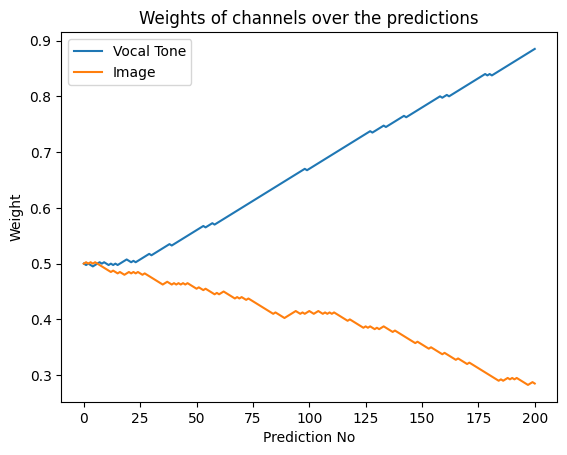

In [51]:
import random
import numpy as np
import matplotlib.pyplot as plt
#Imports for VocalTone
import joblib 
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import math
#Imports for Text
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch
import pickle
import joblib
import os
#Imports for Image
import cv2
from tensorflow.keras.models import load_model

#-------------------Load Data----------------------------------------

def loadData(paths, channels):
    AllData = [0,0,0]
    if(channels[0]):
        AllData[0] = loadVocalToneData(paths[0])
    if(channels[1]):
        AllData[1] = loadTextData(paths[1])
    if(channels[2]):
        AllData[2] = loadImageData(paths[2])
    return AllData

def loadVocalToneData(path):
    x = [[],[],[],[]]
    observed_emotions = ['Angry', 'Happy', 'Neutral', 'Sad']
    
    def extract_feature(file_name, mfcc, chroma, mel):
        X, sample_rate = librosa.load(os.path.join(file_name),res_type='kaiser_fast')
        if chroma:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfcc = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result,mfcc))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
        return result

    for index,folder in enumerate(observed_emotions):
        filepath = os.path.join(path,folder)
        for filename in os.listdir(filepath):
            feature = extract_feature(os.path.join(filepath,filename), mfcc=True, chroma=True, mel=True)
            x[index].append(feature)
    return x

def loadTextData(path): 
    emotion_folders = ["Happy", "Sad", "Angry", "Neutral"]
    # Initialize the list to hold the data arrays for each emotion
    data = [[] for _ in range(len(emotion_folders))]
    
    # Iterate over each emotion folder
    for idx, folder in enumerate(emotion_folders):
        folder_path = os.path.join(path, folder)
        if not os.path.isdir(folder_path):
            print(f"Warning: Folder '{folder_path}' does not exist.")
            continue
        
        # Get the list of .txt files in the folder
        files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
        
        # Read each file and append its content to the respective list
        for file in files:
            file_path = os.path.join(folder_path, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read().strip()
                data[idx].append(content)
    
    return data

def loadImageData(path):
    # Define the list of emotion labels
    classes = ['Angry', 'Happy', 'Neutral', 'Sad']

    # Initialize lists to store the images and corresponding labels
    x = [[],[],[],[]]
    # Loop through each emotion class folder
    for label, emotion in enumerate(classes):
        # Construct the path to the folder containing images for the current emotion
        emotion_dir = os.path.join(path, emotion)
        
        # Loop through each image file in the emotion class folder
        for img_file in os.listdir(emotion_dir):
            # Read the image file
            img_path = os.path.join(emotion_dir, img_file)
            img = cv2.imread(img_path)
            
            # Preprocess the image (resize, normalize, etc.)
            img = cv2.resize(img, (224, 224))  # Resize the image to match your model's input size
            img = img / 255.0  # Normalize pixel values to the range [0, 1]
            
            # Append the preprocessed image and its label to the lists
            x[label].append(img)
        
    return x


#-------------------Load Models----------------------------------------

def loadModels(paths, channels):
    AllModels = [0,0,0]
    if(channels[0]):
        AllModels[0] = loadVocalToneModel(paths[0])
    if(channels[1]):
        AllModels[1] = loadTextModel(paths[1])
    if(channels[2]):
        AllModels[2] = loadImageModel(paths[2])
        
    return AllModels

def loadVocalToneModel(path):
    model = joblib.load(path)
    return model

def loadTextModel(path):
    model = joblib.load(path)
    return model

def loadImageModel(path):
    model = load_model(path)
    return model

#-------------------Create Dataset----------------------------------------

def createWholeDataSet(loadedDataset, sizeOfClass, channels):
    classOrder = [0] * sizeOfClass + [1] * sizeOfClass + [2] * sizeOfClass + [3] * sizeOfClass
    random.shuffle(classOrder)
    AllData = []
    currentIndex = [0,0,0,0]
    for i in classOrder:
        dataPack = [0,0,0]
        if(channels[0]):
            dataPack[0] = loadedDataset[0][i][currentIndex[i]]
        if(channels[1]):
            dataPack[1] = loadedDataset[1][i][currentIndex[i]]
        if(channels[2]):
            dataPack[2] = loadedDataset[2][i][currentIndex[i]]
        currentIndex[i] += 1
        AllData.append(dataPack)
    return AllData, classOrder


#-------------------Predict----------------------------------------

def predSingleVocalTone(model, x):
    X = np.array([x])
    output = model.predict(X)[0]
    return output

def predSingleText(model, x):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    inputs = tokenizer(x, return_tensors="pt").to(device)
    # Perform inference
    emo = model(**inputs)

    logits = emo.logits.to(device)
    print(logits)
    emotion_labels = ["Happy", "Sad","Angry","Neutral" ]
    output = emotion_labels[torch.argmax(logits, dim=1).item()]
    return output

def predSingleImage(model, x):
    # Reshape image to match model's input shape (1, 224, 224, 3)
    x = np.expand_dims(x, axis=0)
    # Perform prediction
    prediction = model.predict(x)
    # Map the predicted class index to emotion label
    emotion_labels = ['Angry', 'Happy', 'Neutral', 'Sad']
    # Get the predicted class
    predicted_class = np.argmax(prediction)
    output = emotion_labels[predicted_class]
    return output

def PredictDataPack(dataPack, models, channels):
    prediction = [[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    if(channels[0]):
        prediction[0] = predProbSingleVocalTone(models[0], dataPack[0])
    if(channels[1]):
        prediction[1] = predProbSingleText(models[1], dataPack[1])
    if(channels[2]):
        prediction[2] = predProbSingleImage(models[2], dataPack[2])
    return prediction

def predProbSingleVocalTone(model, x):
    X = np.array([x])
    output = model.predict_proba(X)[0]
    return output

def predProbSingleText(model, x):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    inputs = tokenizer(x, return_tensors="pt").to(device)
    # Perform inference
    emo = model(**inputs)
    logits = emo.logits.to(device)

    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Convert probabilities tensor to list
    probabilities_list = probabilities.squeeze().tolist()
    # reorder to Angry, Happy, Neutral, Sad
    output = [probabilities_list[i] for i in [2, 0, 3, 1]]
    
    return np.array(output)

def predProbSingleImage(model, x):
    # Reshape image to match model's input shape (1, 224, 224, 3)
    x = np.expand_dims(x, axis=0)
    # Perform prediction and calculate probabilities
    output = model.predict(x)
    return output[0]

#-------------------Process of Training and updating weights----------------------------------------

def Process(WholeDataSetX, WholeDataSetY, models, Classes, weights, channels, round, mechanism):
    predictions = []
    WeightCast = []
    WeightCast.append(GetActiveChannelParameters(weights, channels))
    for index,dataPack in enumerate(WholeDataSetX):
        Prediction = PredictDataPack(dataPack, models, channels)
        finalResult = [0,0,0,0]
        PredictedClasses = [0,0,0]
        if(channels[0]):
            finalResult += Prediction[0]*weights[0]
            PredictedClasses[0] = np.argmax(Prediction[0])
        if(channels[1]):
            finalResult += Prediction[1]*weights[1]
            PredictedClasses[1] = np.argmax(Prediction[1])
        if(channels[2]):
            finalResult += Prediction[2]*weights[2]
            PredictedClasses[2] = np.argmax(Prediction[2])

        finalResultIndex = np.argmax(finalResult)
        finalResultClass = Classes[finalResultIndex]
        predictions.append(finalResultIndex)

        print("Round No " + str(round) + " -")
        PrintPrediction(Prediction, PredictedClasses, channels)
        print("Weight : " + str(GetActiveChannelParameters(weights, channels)))
        print("Final Prediction : " + str(finalResult) + " -> " + str(finalResultIndex), end="  |  ")
        print(str(WholeDataSetY[index]) + " <- Actual Class\n")
        
        weights = updateWeights(weights, Prediction, PredictedClasses, WholeDataSetY[index], round, channels, mechanism)
        WeightCast.append(GetActiveChannelParameters(weights, channels))
        round+=1

    print(accuracy_score(WholeDataSetY,predictions))
    return WeightCast

def GetActiveChannelParameters(parameters, channels):
    ActiveParameters = []
    if(channels[0]):
        ActiveParameters.append(parameters[0])
    if(channels[1]):
        ActiveParameters.append(parameters[1])
    if(channels[2]):
        ActiveParameters.append(parameters[2])
    return ActiveParameters

def updateWeights(weights, predictions_proba, predictedClasses, TrueClass, round, channels, mechanism):
    if mechanism == 1: 
        #Change weights by a constant 
        rate = 0.0025
        for i in range(3):
            if(channels[i]):
                if predictedClasses[i] == TrueClass:
                    weights[i] += rate
                else:
                    weights[i] -= rate
    
    elif mechanism == 2:
        #Change weights according to the predcting accuracies of individual models
        for i in range(3):
            if(channels[i]):
                if predictedClasses[i] == TrueClass:
                    weights[i] = ((weights[i]*(round-1))+1)/round
                else:
                    weights[i] = weights[i]*(round-1)/round

    return weights


#-------------------Analysing and showing results----------------------------------------

def PrintPrediction(predictions, predictedClasses, channels):
    result = [str([round(val,4) for val in predictions[i]]) + " -> " + str(predictedClasses[i]) for i in range(len(predictions))]
    print("Individual Prediction : "+"   |  ".join(GetActiveChannelParameters(result, channels)))
    

def DrawGraph(weights, channels):
    num_lines = len(weights[0])

    Names = []
    if(channels[0]):
        Names.append("Vocal Tone")
    if(channels[1]):
        Names.append("Text")
    if(channels[2]):
        Names.append("Image")
            
    lines = [[] for _ in range(num_lines)]
    for array in weights:
        for i in range(num_lines):
            lines[i].append(array[i])

    for i in range(num_lines):
        plt.plot(lines[i], label=Names[i])
    plt.title('Weights of channels over the predictions')
    plt.xlabel('Prediction No')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()


#-------------------Main Program----------------------------------------

# Order of channels are VocalTone,Text,Image
# Boolean values in channelAvailability array says whether VocalTone,Text,Image channels are available
# So program can be executed for any of the channel or channels
# If Text is the only available channel then pass -> False,True,False 
# Add the model and dataset paths
# Set the SezeeofClass according to available data in a one class
# Initial weights can be set as you want (usually 0.5 is used)
# Updating mechnism can be sekected by setting weightUpdatingMechanism (change by a constant -> 1, change accorind to prediciting accuracy -> 2)
# RoundNo can be set to tell program that how many predictions have already been done to get the initial weights. It is only used in accuracy based mechanism
# If we are stating from 1st round here, the deviation in the weights after the round is larger than the deviation after 100th round  
# Amount by which the weight should be changed after a success/failure can be set in UpdateWeight() method (rate)

SizeOfClass = 50
Emotion_Classes = ['Angry', 'Happy', 'Neutral', 'Sad']
ModelPaths = [  "C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Models\Ensemble\VocalTone\TrainedUsing95percCommonData&IncLearnedUsingPersAllDataBatchSize1.pkl",
                "C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Models\Ensemble\Text\ERM_30.pkl",
                "C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Models\Ensemble\Image\my_model4.h5"]
DatasetPaths = ["C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Personalized\Ensemble\VocalTone",
                "C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Personalized\Ensemble\Text",
                "C:\Ruchira\Academic\.IMMEDIATE\FYP\FYP\Datasets\Personalized\Ensemble\Image"]

channelAvailability = [True, False, True]           #   VocalTone, Text, Image   <- order 
weightUpdatingMechanism = 1                         #   1 or 2
RoundNo = 5                                         #   only used in mechanism 2 above
loadedData = loadData(DatasetPaths, channelAvailability)
loadedModels = loadModels(ModelPaths, channelAvailability)
WholeDataSetX, WholeDataSetY = createWholeDataSet(loadedData, SizeOfClass, channelAvailability)
Weights = [0.5, 0, 0.5]
WeightLine = Process(WholeDataSetX, WholeDataSetY, loadedModels, Emotion_Classes, Weights, channelAvailability, RoundNo, weightUpdatingMechanism)
DrawGraph(WeightLine, channelAvailability)

    
